# Test if SCLC groups are enriched for mutations in the WNT signaling pathway

In [1]:
%matplotlib inline
import csv
import pandas
from matplotlib import pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from scipy import stats

In [2]:
with open('wnt_list') as f:
    wnt_list = set([x.strip().upper() for x in f])

In [3]:
with open('ensembl_74_37_gene_names.txt') as f:
    ensembl_genes = set([x.strip().upper() for x in f])

In [4]:
# Coverage files pulled from /gscmnt/gc2547/mardiswilsonlab/kkrysiak/SCLC/music/smg_v7_merge_roi_noMT_noSCLC10_newBMRcalc/gene_covgs
covg_dfs = []
for i in range(1, 19):
    if i==10:
        continue
    with open('gene_covgs/SCLC{0}.covg'.format(i)) as f:
        p = pandas.read_csv(f, sep='\t')
        covg_dfs.append(p)

In [5]:
# SNV / Indel file pulled from /gscmnt/sata132/techd/zskidmor/projects/SCLC/misc/Dec_2015/Analysis/somatic_analysis/master_snvs_indels_somatic.anno.rcnt.filtered.tsv
with open('snv_indels.tsv') as f:
    variant_calls = pandas.read_csv(f, sep='\t', low_memory=False)
# Filter out non-rep samples
idx = ~variant_calls['Extraction_id'].isin([1316882,1316875,1316877,1316874,1316920,1316919,1316921])
variant_calls = variant_calls[idx]


In [6]:
wnt_list <= ensembl_genes

True

In [7]:
df = pandas.concat([x['Covered'] / x['Length'] for x in covg_dfs], axis=1)
max_dist = df.max(axis=1)

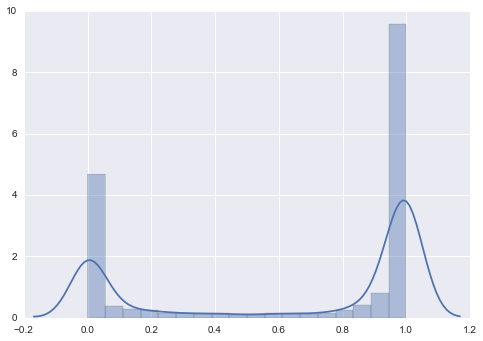

In [8]:
sns.distplot(max_dist)

In [9]:
idx = max_dist != 0
# A gene is considered "covered" if there is non-zero coverage over that gene in at least one sample

In [10]:
covered_genes = set(covg_dfs[0]['#Gene'][idx])
covered_genes <= ensembl_genes

False

In [11]:
len(covered_genes)

30893

In [12]:
covered_genes_with_symbol = covered_genes & ensembl_genes
# This excludes "covered genes" that use ENS IDs, ORFs, or LOC ids as labels. This needs to be fixed.
len(covered_genes_with_symbol)

22517

In [13]:
wnt_list.issubset(covered_genes_with_symbol)

False

In [14]:
wnt_list - (wnt_list & covered_genes_with_symbol)

{'H2BFS'}

In [15]:
covered_wnt_list = wnt_list & covered_genes_with_symbol
len(covered_wnt_list)

294

In [16]:
covered_non_wnt_list = covered_genes_with_symbol - covered_wnt_list

In [17]:
genes_with_variants = set(variant_calls['gene_name'])

In [18]:
a = covered_wnt_list & genes_with_variants
b = covered_wnt_list - a
c = covered_non_wnt_list & genes_with_variants
d = covered_non_wnt_list - c
lengths = [len(x) for x in (a,b,c,d)]
x = np.matrix('{0} {1}; {2} {3}'.format(*lengths))
stats.chi2_contingency(x)

(1.9676888967748787,
 0.16069338635123342,
 1,
 array([[    62.71181774,    231.28818226],
        [  4740.28818226,  17482.71181774]]))

In [19]:
x

matrix([[   73,   221],
        [ 4730, 17493]])

WNT genes do not appear to be enriched compared to overall number of observed genes across the cohort. (p-value = 0.17)

In [20]:
relapse_genes_idx = variant_calls['Tissue_type'] == 'relapse'
primary_genes_idx = variant_calls['Tissue_type'] == 'primary'

primary_genes = set(variant_calls[primary_genes_idx]['gene_name'])
relapse_genes = set(variant_calls[relapse_genes_idx]['gene_name'])

a = covered_wnt_list & primary_genes
b = primary_genes - a
c = covered_wnt_list & relapse_genes
d = relapse_genes - c
lengths = [len(x) for x in (a,b,c,d)]
x = np.matrix('{0} {1}; {2} {3}'.format(*lengths))
stats.chi2_contingency(x)

(0.066536027246845694,
 0.79644874995874015,
 1,
 array([[   45.14834471,  2982.85165529],
        [   72.85165529,  4813.14834471]]))

In [21]:
x

matrix([[  47, 2981],
        [  71, 4815]])

WNT genes do not appear to be enriched in primary vs. relapse. (p = 1)

In [22]:
paired_samples = ['SCLC{0}'.format(x) for x in (1,2,3,5,6,8,16,17,18)]
idx = variant_calls['Common_name'].isin(paired_samples)
paired_variant_calls = variant_calls[idx]

relapse_genes_idx = paired_variant_calls['Tissue_type'] == 'relapse'
primary_genes_idx = paired_variant_calls['Tissue_type'] == 'primary'

primary_genes = set(paired_variant_calls[primary_genes_idx]['gene_name'])
relapse_genes = set(paired_variant_calls[relapse_genes_idx]['gene_name'])

a = covered_wnt_list & primary_genes
b = primary_genes - a
c = covered_wnt_list & relapse_genes
d = relapse_genes - c
lengths = [len(x) for x in (a,b,c,d)]
x = np.matrix('{0} {1}; {2} {3}'.format(*lengths))
stats.chi2_contingency(x)

(0.0073053427398991752,
 0.93188671302547066,
 1,
 array([[   47.91958495,  2968.08041505],
        [   50.08041505,  3101.91958495]]))

In [23]:
x

matrix([[  47, 2969],
        [  51, 3101]])

WNT genes do not appear to be enriched in primary vs. relapse when limited to paired samples (which is expected).

In [24]:
# Profiled WNT genes
len(covered_wnt_list)

294

In [25]:
# WNT genes observed in paired cohort
len(covered_wnt_list & (primary_genes | relapse_genes))

55

In [26]:
# "Relapse-specific" WNT genes
len(covered_wnt_list & (relapse_genes - primary_genes))

8

In [27]:
covered_wnt_list & (relapse_genes - primary_genes)

{'APC', 'CHD8', 'DVL3', 'PLCB2', 'PRKG2', 'SMARCA4', 'WNT1', 'YWHAZ'}

In [28]:
def paired_count(gene):
    idx = paired_variant_calls['gene_name'] == gene
    a = paired_variant_calls[idx]
    primary = len(a[a['Tissue_type'] == 'primary'])
    relapse = len(a) - primary
    return primary, relapse

def total_count(gene):
    idx = variant_calls['gene_name'] == gene
    a = variant_calls[idx]
    primary = len(a[a['Tissue_type'] == 'primary'])
    relapse = len(a) - primary
    return primary, relapse


In [29]:
with open('WNT_genes.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Gene Name', 'Paired Primary Tumors', 'Paired Relapse Tumors', 'Total Primary Tumors', 'Total Matched Tumors','Specificity'])
    for gene in sorted(covered_wnt_list):
        primary = gene in primary_genes
        relapse = gene in relapse_genes
        if primary and relapse:
            out = 'Non-specific'
        elif primary:
            out = 'Primary-specific'
        elif relapse:
            out = 'Relapse-specific'
        else:
            out = 'No mutations'
        primary, relapse = paired_count(gene)
        total_primary, total_relapse = total_count(gene)
        writer.writerow([gene, primary, relapse, total_primary, total_relapse, out])
    